In [33]:
#Imports
import pandas as pd
import matplotlib as mpl
from mplsoccer.pitch import VerticalPitch, Pitch
from matplotlib.colors import to_rgba
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colorbar
from matplotlib.colors import LinearSegmentedColormap
from highlight_text import fig_text
import ipywidgets as widgets
import math
from scipy.spatial import ConvexHull
from scipy import stats
from scipy.ndimage import gaussian_filter

#Remove warning
pd.options.mode.chained_assignment = None

#Read Data
df = pd.read_csv('Footballdata/Others/MS/SogdianavsKL.csv')

Eventdf = pd.read_csv('OptaEventName.csv')

#Merge to obtain accurate position of player
df = pd.merge(df, Eventdf, on="typeId").sort_values('timeStamp', ascending = True).reset_index()

#Get Headers, endX and endY
df['endX'] = 0.0
df['endY'] = 0.0
df['head'] = 0
df['Cross'] = 0
df['SetPiece'] = 0
df['FreeKick'] = 0
df['CornerKick'] = 0
df['ThrowIn'] = 0
df['Error'] = 0
df['Length'] = 0.0
df['BlockedX'] = 0.0
df['BlockedY'] = 0.0
df['GoalMouthY'] = 0.0
df['GoalMouthZ'] = 0.0

type_cols = [col for col in df.columns if '/qualifierId' in col]
for i in range(len(df)):
    df1 = df.iloc[i:i+1,:]
    x = 0 
    for x in range(len(type_cols)):
        col = df1[type_cols[x]].values[0]
        if col == 140:
            endx = df1.loc[:,'qualifier/%i/value' %x].values[0]
            df['endX'][i] = endx
        else:
            x +=1
    y = 0
    for y in range(len(type_cols)):
        col = df1[type_cols[y]].values[0]
        if col == 141:
            endy = df1.loc[:,'qualifier/%i/value' %y].values[0]
            df['endY'][i] = endy
        else:
            y +=1
    h = 0
    for h in range(len(type_cols)):
        col = df1[type_cols[h]].values[0]
        if col == 15:
            head = df1.loc[:,'qualifier/%i/value' %h].values[0]
            df['head'][i] = 1
        else:
            h +=1  
    c = 0
    for c in range(len(type_cols)):
        col = df1[type_cols[c]].values[0]
        if col == 2:
            cross = df1.loc[:,'qualifier/%i/value' %c].values[0]
            df['Cross'][i] = 1
        else:
            c +=1          
    fk = 0
    for fk in range(len(type_cols)):
        col = df1[type_cols[fk]].values[0]
        if col == 5:
            fk = df1.loc[:,'qualifier/%i/value' %fk].values[0]
            df['FreeKick'][i] = 1
        else:
            fk +=1  
    ck = 0
    for ck in range(len(type_cols)):
        col = df1[type_cols[ck]].values[0]
        if col == 6:
            ck = df1.loc[:,'qualifier/%i/value' %ck].values[0]
            df['CornerKick'][i] = 1
        else:
            ck +=1  
    ti = 0
    for ti in range(len(type_cols)):
        col = df1[type_cols[ti]].values[0]
        if col == 107:
            ti = df1.loc[:,'qualifier/%i/value' %ti].values[0]
            df['ThrowIn'][i] = 1
        else:
            ti +=1
    e = 0
    for e in range(len(type_cols)):
        col = df1[type_cols[e]].values[0]
        if col == 169:
            e = df1.loc[:,'qualifier/%i/value' %e].values[0]
            df['Error'][i] = 1
        else:
            e +=1
    l = 0
    for l in range(len(type_cols)):
        col = df1[type_cols[l]].values[0]
        if col == 212:
            length = df1.loc[:,'qualifier/%i/value' %l].values[0]
            df['Length'][i] = length
        else:
            l +=1
    sp = 0
    for sp in range(len(type_cols)):
        col = df1[type_cols[sp]].values[0]
        if ((col == 5) | (col == 6) | (col == 107)):
            sp = df1.loc[:,'qualifier/%i/value' %sp].values[0]
            df['SetPiece'][i] = 1
        else:
            sp +=1
    bx = 0 
    for bx in range(len(type_cols)):
        col = df1[type_cols[bx]].values[0]
        if col == 146:
            blockx = df1.loc[:,'qualifier/%i/value' %bx].values[0]
            df['BlockedX'][i] = blockx
        else:
            bx +=1
    by = 0 
    for by in range(len(type_cols)):
        col = df1[type_cols[by]].values[0]
        if col == 147:
            blocky = df1.loc[:,'qualifier/%i/value' %by].values[0]
            df['BlockedY'][i] = blocky
        else:
            by +=1
    gy = 0
    for gy in range(len(type_cols)):
        col = df1[type_cols[gy]].values[0]
        if col == 102:
            goaly = df1.loc[:,'qualifier/%i/value' %gy].values[0]
            df['GoalMouthY'][i] = goaly
        else:
            gy +=1            
    gz = 0
    for gz in range(len(type_cols)):
        col = df1[type_cols[gz]].values[0]
        if col == 103:
            goalz = df1.loc[:,'qualifier/%i/value' %gz].values[0]
            df['GoalMouthZ'][i] = goalz
        else:
            gz +=1             

#Adjust to pitch
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8
df['BlockedX'] = df['BlockedX']*1.2
df['BlockedY'] = df['BlockedY']*.8

#Make a new, single column for time and sort the events in chronological order
df["Time"] = (60*df["timeMin"]) + df["timeSec"]

#New Column for Headers
df['Headers'] = np.where(((df['head'] == 1) | ((df['typeName'] == 'Aerial') & (df['outcome'] == 1))), 1, 0)

#Remove unwanted variables
df = df.loc[~(df['typeName'] == 'Player off')]
df = df.loc[~(df['typeName'] == 'Player on')]
df = df.loc[~(df['typeName'] == 'Start delay')]
df = df.loc[~(df['typeName'] == 'End delay')]
df = df.loc[~(df['typeName'] == 'Formation change')]
df = df.loc[~(df['typeName'] == 'Collection End')]
df = df.loc[~(df['typeName'] == 'Team set up')]
df = df.loc[~(df['typeName'] == 'Deleted event')]

#New Column Next & Prev Event
df['Prev'] = df['typeName'].shift(1)

#Check previous team to ensure it is not from the same team later on
df['prevteam'] = df['contestantId'].shift(1)

#Check previous team to ensure it is not from the same team later on
df['prevteam2'] = df['contestantId'].shift(2)

#Change Offside Passes to Passes
df = df.replace('OffsidePass', 'Pass')

#Remove corner kicks
df = df.loc[~(df['x'] > 119.35)]

#Remove throw-ins
df = df.loc[(df['y'].between(0.5,79.9))]

#Remove passes that come after fouls and cards, potential set pieces
df = df.loc[~((df['typeName'] == 'Pass') & (df['Prev'] == 'Foul'))]
df = df.loc[~((df['typeName'] == 'Pass') & (df['Prev'] == 'Card'))]

#New Column for Assists
df['Assist']= np.where((df['keyPass'] == 1) & (df['typeName'].shift(-1) == 'Goal'),1,0)

#New Column for Assists
df['Goal']= np.where(df['typeName'] == 'Goal',1,0)

#Change Key Passes to 0
df['keyPass'] = df['keyPass'].fillna(0).astype(int)

#relevant variables
df= df[['id','Time','playerName','Number','contestantId','typeName','x','y','endX','endY', 'Length',"FreeKick",
        "CornerKick","ThrowIn",'SetPiece','Headers','Cross','keyPass','Assist','Error','BlockedX',
        'BlockedY', 'GoalMouthY', 'GoalMouthZ','Goal','outcome','Prev','prevteam','prevteam2']]

df.rename(columns = {'playerName':'Player', 'contestantId':'Team', 'id':'ID',
                     'typeName':'Event', 'keyPass':'KeyPass', 'outcome':'Outcome'}, inplace = True)

#New Column for Ball Touch
df['BallTouch']= np.where((df['Event'] == 'Pass') |
                          (df['Event'] == 'Offside Pass') | 
                          (df['Event'] == 'Take On') | 
                          (df['Event'] == 'Claim') | 
                          (df['Event'] == 'Miss') | 
                          (df['Event'] == 'Post') | 
                          (df['Event'] == 'Clearance') | 
                          (df['Event'] == 'Save') | 
                          (df['Event'] == 'Interception') | 
                          (df['Event'] == 'Tackle') | 
                          (df['Event'] == 'Goal') | 
                          (df['Event'] == 'Attempt Saved') | 
                          (df['Event'] == 'Dispossessed') | 
                          (df['Event'] == 'Punch') | 
                          (df['Event'] == 'Good Skill') |                  
                          (df['Event'] == 'Keeper pick-up') | 
                          (df['Event'] == 'Ball recovery') | 
                          (df['Headers'] == 1) | 
                          (df['Event'] == 'Ball touch') &
                          (df['SetPiece'] == 0),1,0)

#Only obtaining defensive actions happening beyond 40% of the pitch for team in question
df1 = df.loc[(df['x']>48)]

#Calculating passes that occur below 60% of the pitch for opposition
df2 = df.loc[(df['x']<72)]


#Combo box, choose team
options = df["Team"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
teamlist = widgets.Combobox(
    placeholder='Enter a team',
    options=options,
    description='Team:',
    ensure_option=True,
    disabled=False
)
teamlist

Combobox(value='', description='Team:', ensure_option=True, options=('FC Sogdiana', 'Kuala Lumpur City FC'), p…

In [34]:
#Remove Warning
pd.options.mode.chained_assignment = None

#Retrieve Team
team = teamlist.value

#Retrieve Opposition team (only use when there's two available teams for selection)
oppo = df.loc[(df['Team']!= team)]
oppo = oppo['Team'].unique()
oppo = oppo[0]

#List down relevant defensive actions
list1 = ["Interception","Tackle","Foul","Challenge",'Blocked Pass']

#Get total of defensive actions
Defensive_Actions1 = df1.loc[((df1['Team'] == team ) & (df1['Event'].isin(list1)) & (df1['prevteam'] == oppo))]

#Remove Fouls that are successful, not traditional fouls
Defensive_Actions1 = Defensive_Actions1.loc[~((Defensive_Actions1['Event'] == 'Foul') &
                                             (Defensive_Actions1['Outcome'] == 1))]

#Filter for Aerials that occur when player competes, need to make sure they are attempting to intercept a pass 
Headers1 = df1.loc[(df1['Team'] == team) &
                   (df1['Event'] == 'Aerial') &
                   (df1 ['Outcome'] == 'Unsuccessful') &
                   (df1['Prev'] == 'Aerial') &
                   (df1['prevteam'] == oppo)]

#take out headers that are failed. Intended to pass to them but failed their duel
Headers1 = Headers1.loc[~((Headers1['prevteam2'] == team))]

#Filter for Aerials that occur when player intercepts a high ball, or wins an aerial duel
Headers2 = df1.loc[(df1['Team'] == team) &
                   (df1['Event'] == 'Aerial') &
                   (df1 ['Outcome'] == 'Successful') &
                   (df1['prevteam'] == oppo)]

#combining the two dataframes
Headers = [Headers1 , Headers2]
Headers = pd.concat(Headers)


shoteventlist = ['Goal','SavedShot','ShotOnPost','MissedShots']
#Take out headers inside the attacking box, likely set piece headers
Headers = Headers.loc[~((Headers['Event'].isin(shoteventlist)))]

#Combining aerials with the rest of the defensive actions
Defensive_Actions2 = [Defensive_Actions1 , Headers]
Defensive_Actions = pd.concat(Defensive_Actions2)

#Get total
action = len(Defensive_Actions.index)

In [35]:
#Get total of opposition passes (not sure if we should include successful passes)
Passes_Allowed = df2.loc[((df2['Team'] == oppo) & (df2['Event'] == 'Pass'))]
#Passes_Allowed = df2.loc[((df['Team'] == oppo) & (df2['Event'] == 'Pass') & (df['Outcome'] == 'Successful'))]
passes = len(Passes_Allowed.index)

#Calculating PPDA
PPDA = passes / action
PPDA =  round(PPDA, 2)

#Overview
print(team)
print("Passes Allowed: "+ str(passes))
print("Defensive Actions: "+ str(action))
print("PPDA: "+ str(PPDA))

#Need home team to be displayed on the left, so need to find the absolute values
Passes_Allowed['x'] = Passes_Allowed['x']-120
Passes_Allowed['y'] = Passes_Allowed['y']-80
Passes_Allowed['x'] = Passes_Allowed['x'].abs()
Passes_Allowed['y'] = Passes_Allowed['y'].abs()

#Want to obtain Kit Number for annotation purposes on defensive actions
Def = Defensive_Actions[['Player','Number','x','y']].reset_index(drop=True)
Def.rename(columns = {'Number':'Num'},inplace = True)
Def['Num'] = Def['Num'].astype(int)
Def.index += 1

Kuala Lumpur City FC
Passes Allowed: 401
Defensive Actions: 20
PPDA: 20.05


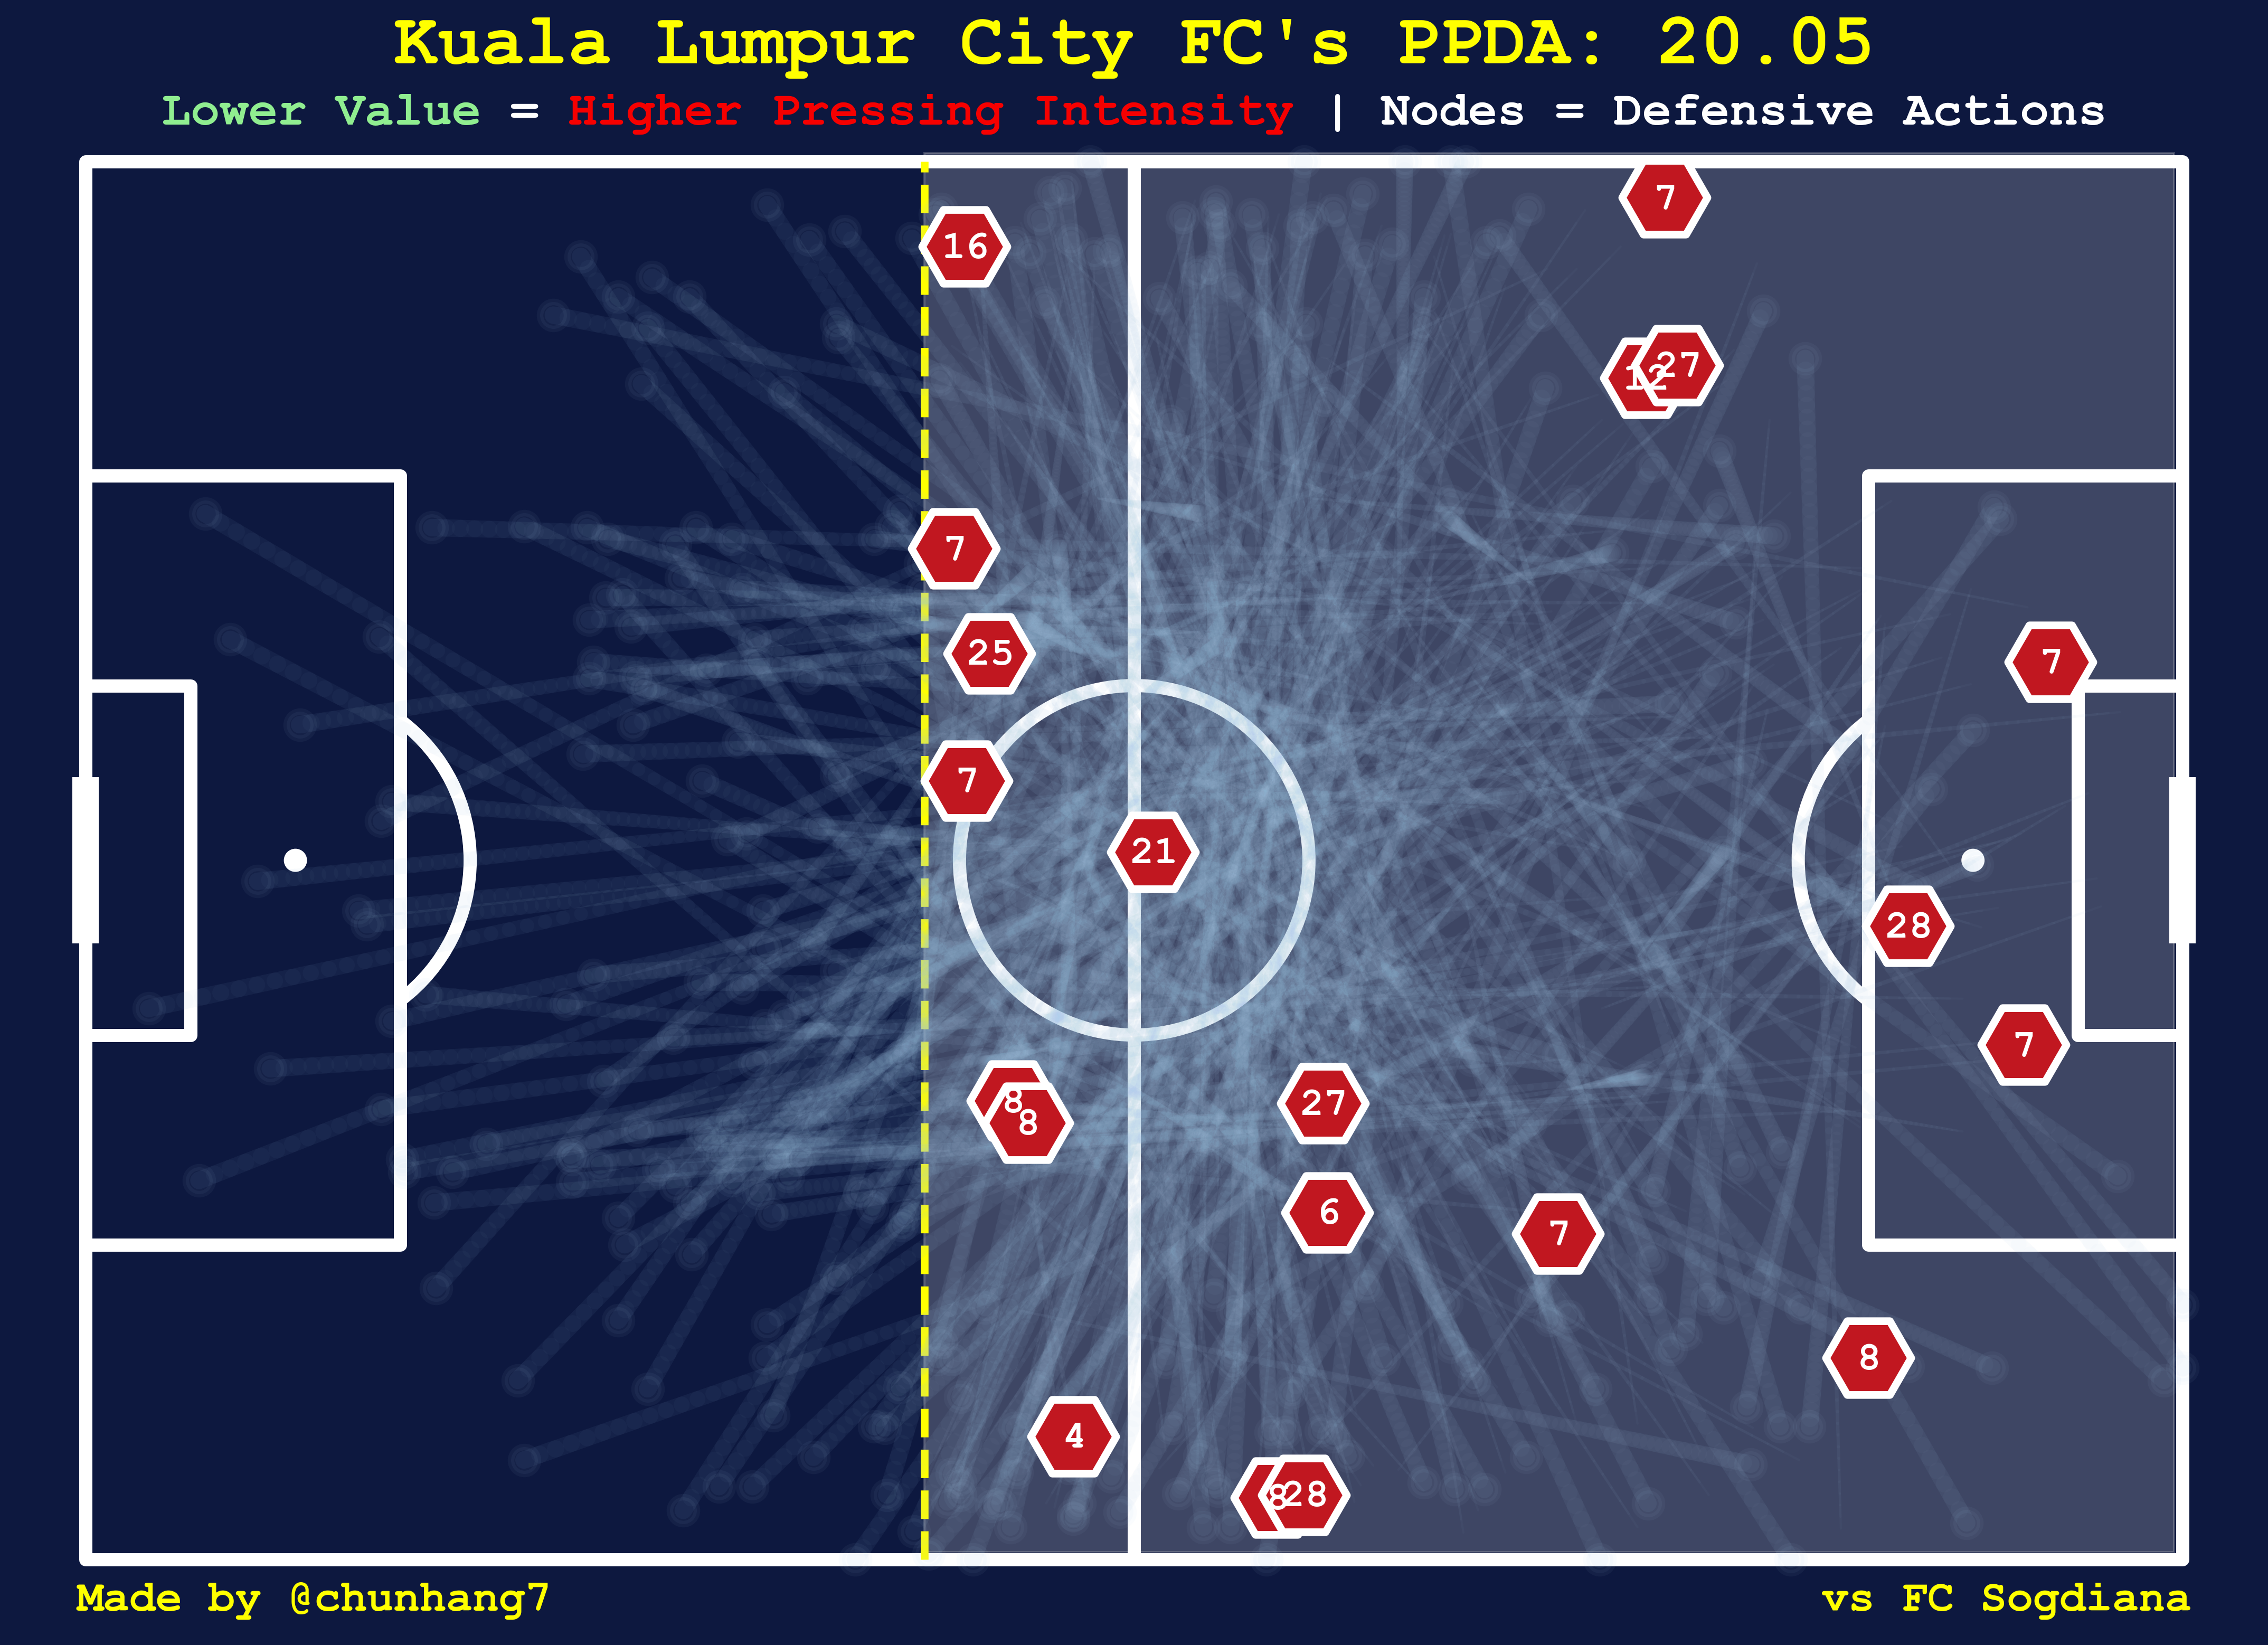

In [36]:
#dpi
mpl.rcParams['figure.dpi'] = 300

#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0d183f', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0d183f')

#Draw line
ax.plot([48,48], [0, 80], c='yellow', lw=3.5,ls='--')

#inverse y-axis
plt.gca().invert_yaxis()

#plot the team's defensive actions
plt.scatter(Defensive_Actions.x, Defensive_Actions.y, marker='H', s=1500, c='#c11720', 
            linewidth = 3.5, edgecolor='w',zorder=5)

#plot passes made by opposition
pitch.lines(Passes_Allowed.x,Passes_Allowed.y,Passes_Allowed.endX,Passes_Allowed.endY,
            comet=True,ax=ax, linewidth=8, capstyle='round', zorder=2,
            alpha=0.03, color ='#aacfec')

pitch.scatter(Passes_Allowed['endX'], Passes_Allowed['endY'],
              edgecolors= "#aacfec", c="#aacfec", s = 150, zorder=2, ax=ax, 
              marker = 'o', alpha = 0.05,linewidths=3)

#shade
plt.axvspan(48,119.5,ymin=0.05,ymax=0.96,color='lightgrey',zorder=-1,alpha=0.25)

#Kit Numbers on Nodes
for index, row in Def.iterrows():
    pitch.annotate(row.Num, xy=(row.x+0.05,row.y-0.15), c='w', va='center', ha='center', 
                   size=18, fontweight='bold', fontfamily="Courier New",ax=ax,zorder=6)
                                    
#Title & Annotations
fig.suptitle(team +"'s PPDA: "+str(PPDA)+"\n", fontsize=33, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.94)

#highlights
highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "#f60000","fontweight": 'bold'}
    ]

Title = fig_text(s = "<Lower Value> = <Higher Pressing Intensity> | Nodes = Defensive Actions" ,
        x = 0.5, y = 0.895, highlight_textprops = highlight_textprops ,color='w',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=22);

#Annotations
fig.text(0.255, 0.03, 'Made by @chunhang7', fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

fig.text(0.945, 0.03,'vs ' + oppo, fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

plt.show()